In [9]:
import numpy as np
from matplotlib import pyplot as plt
from groupyr import LogisticSGL
from groupyr.logistic import WeightedLogisticSGL
import pandas as pd
from pca import (pca, logistic_pca)
import linearcorex as lc
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.metrics as metrics


In [2]:
def mark_as_categorical(dataframe: pd.DataFrame, category: str):
    dataframe[category] = dataframe[category].astype('category')

def get_categories(dataframe: pd.DataFrame):
    return [col for col in dataframe.select_dtypes(include="category")]

In [3]:
def create_groups_from_1hot(data_frame: pd.DataFrame):
    expanded = pd.get_dummies(data_frame)
    groups = {col: [] for col in data_frame}
    for idx, col in enumerate(expanded):
        category = col.split("_")[0]
        groups[category].append(idx)

    groups = {k: np.array(v) for k, v in groups.items()}
    return expanded, groups

In [4]:
kid_data = pd.read_csv("data.csv", delimiter=";")

In [5]:
mark_as_categorical(kid_data, "MaritalStatus")
mark_as_categorical(kid_data, "ApplicationMode")
mark_as_categorical(kid_data, "ApplicationOrder")
mark_as_categorical(kid_data, "TimeOfDay")
mark_as_categorical(kid_data, "PreviousQualification")
mark_as_categorical(kid_data, "Nationality")
mark_as_categorical(kid_data, "MotherQualification")
mark_as_categorical(kid_data, "FatherQualification")
mark_as_categorical(kid_data, "MotherOccupation")
mark_as_categorical(kid_data, "FatherOccupation")
mark_as_categorical(kid_data, "Course")
target = kid_data.get("Target").replace(['Dropout', 'Graduate', 'Enrolled'], [0, 1, 2]).astype(float),


for col in kid_data.select_dtypes(include=["float64", "int"], exclude="category"):
    kid_data[col] /= kid_data[col].max()

expanded_X, group_idxs = create_groups_from_1hot(kid_data.drop(columns="Target"))
expanded_X

,PreviousGrade,AdmissionGrade,Displaced,SpecialNeeds,Debtor,TuitionPaid,Gender,Scholarship,Age,International,...,FatherOccupation_172,FatherOccupation_174,FatherOccupation_175,FatherOccupation_181,FatherOccupation_182,FatherOccupation_183,FatherOccupation_192,FatherOccupation_193,FatherOccupation_194,FatherOccupation_195
0,0.642105,0.670000,1.0,0.0,0.0,1.0,1.0,0.0,0.285714,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.842105,0.750000,1.0,0.0,0.0,0.0,1.0,0.0,0.271429,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.642105,0.656842,1.0,0.0,0.0,0.0,1.0,0.0,0.271429,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.642105,0.629474,1.0,0.0,0.0,1.0,0.0,0.0,0.285714,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.526316,0.744737,0.0,0.0,0.0,1.0,0.0,0.0,0.642857,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,0.657895,0.643158,0.0,0.0,0.0,1.0,1.0,0.0,0.271429,0.0,...,0,0,0,0,0,0,0,0,0,0
4420,0.631579,0.626316,1.0,0.0,1.0,0.0,0.0,0.0,0.257143,1.0,...,0,0,0,0,0,0,0,0,0,0
4421,0.810526,0.786842,1.0,0.0,0.0,1.0,0.0,1.0,0.428571,0.0,...,0,0,0,0,0,0,0,0,0,0
4422,0.947368,0.809474,1.0,0.0,0.0,1.0,0.0,1.0,0.285714,0.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
kid_data.get("Target").value_counts()

Graduate    2209
Dropout     1421
Enrolled     794
Name: Target, dtype: int64

In [7]:
get_categories(kid_data)

['MaritalStatus',
 'ApplicationMode',
 'ApplicationOrder',
 'Course',
 'TimeOfDay',
 'PreviousQualification',
 'Nationality',
 'MotherQualification',
 'FatherQualification',
 'MotherOccupation',
 'FatherOccupation']

In [8]:
from groupyr import LogisticSGLCV
from sklearn.model_selection import train_test_split


X = expanded_X.to_numpy(np.float64)
y = kid_data['Target'].replace(['Dropout', 'Graduate', 'Enrolled'], [1, 0, 2]).to_numpy(np.float64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(y_train.shape)

(3539, 255)
(3539,)


Study of OnevRest

In [16]:
def standard_metrics(model, label=""):
    y_pred = model.predict(X_test)
    print("Stats for", label)
    print(metrics.confusion_matrix(y_test, y_pred))
    print("F1 score", metrics.f1_score(y_test, y_pred, average=None))
    print("Training Score", model.score(X_train, y_train))
    print("Testing Score", model.score(X_test, y_test))

In [17]:
from sklearn.multiclass import OneVsRestClassifier
model = LogisticRegression(penalty='l2', max_iter=10000)


one_v_all_log_r = OneVsRestClassifier(model).fit(X_train, y_train)
model = model.fit(X_train, y_train)

standard_metrics(one_v_all_log_r, "OneVsRest")
standard_metrics(model, "Softmax")

Stats for OneVsRest
[[405  13  16]
 [ 41 215  20]
 [ 70  43  62]]
F1 score [0.85263158 0.78610603 0.45421245]
Training Score 0.7903362531788641
Testing Score 0.7706214689265537
Stats for Softmax
[[397  16  21]
 [ 38 214  24]
 [ 62  43  70]]
F1 score [0.8528464  0.77959927 0.48275862]
Training Score 0.8007911839502685
Testing Score 0.7694915254237288


In [27]:
scale=1+0.5/np.mean(y_train),
group_model = LogisticSGL( groups=list(group_idxs.values()), l1_ratio=0, alpha=0.02,
    verbose=2, suppress_solver_warnings=False, max_iter=10000
)
one_v_all = OneVsRestClassifier(group_model, n_jobs=3).fit(X_train, y_train)
#one_v_all = group_model.fit(X_train, y_train)

In [28]:
standard_metrics(one_v_all, "Group Lasso")

Stats for Group Lasso
[[408  18   8]
 [ 38 222  16]
 [ 75  58  42]]
F1 score [0.85445026 0.77351916 0.34854772]
Training Score 0.7671658660638598
Testing Score 0.7593220338983051


In [30]:

group_model.fit(X_train, y_train)

LogisticSGL(alpha=0.02,
            groups=[array([25, 26, 27, 28, 29, 30]),
                    array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48]),
                    array([49, 50, 51, 52, 53, 54, 55, 56]),
                    array([57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]),
                    array([74, 75]),
                    array([76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]),
                    array([0]),
                    array([ 93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 10...
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254]),
                    array([1]), array([2]), array([3]), array([4]), array([5]),
                    array([6]), array([7]), array([8]), array([9]), array([10]),
                    array([11]), array([12]), array([13]), array([14]),
                    array([15]), array([16]), array([17]), array([18]), ...],
            l1_ratio=0, max_iter=10000, suppress_solver_warnings=False,
            verbose=2)

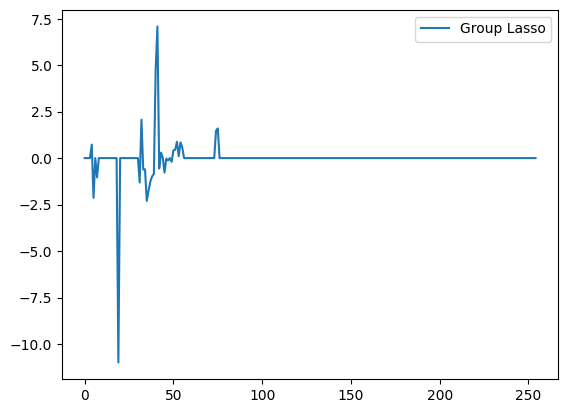

In [31]:
plt.plot(group_model.coef_, label="Group Lasso")
#plt.plot(model.coef_.squeeze(), label="Regular")
plt.legend()

In [32]:
print(expanded_X.columns[abs(group_model.coef_) > 1e-3])
print(expanded_X.columns[np.argmax(abs(group_model.coef_))])

Index(['Debtor', 'TuitionPaid', 'Scholarship',
       'Curricular units 2nd sem (approved)', 'ApplicationMode_1',
       'ApplicationMode_2', 'ApplicationMode_5', 'ApplicationMode_7',
       'ApplicationMode_10', 'ApplicationMode_15', 'ApplicationMode_16',
       'ApplicationMode_17', 'ApplicationMode_18', 'ApplicationMode_26',
       'ApplicationMode_27', 'ApplicationMode_39', 'ApplicationMode_42',
       'ApplicationMode_43', 'ApplicationMode_44', 'ApplicationMode_51',
       'ApplicationMode_53', 'ApplicationOrder_0', 'ApplicationOrder_1',
       'ApplicationOrder_2', 'ApplicationOrder_3', 'ApplicationOrder_4',
       'ApplicationOrder_5', 'ApplicationOrder_6', 'TimeOfDay_0',
       'TimeOfDay_1'],
      dtype='object')
Curricular units 2nd sem (approved)


In [17]:
np.mean(kid_data['Curricular units 1st sem (evaluations)'] >= kid_data['Curricular units 1st sem (enrolled)'])

0.22716998191681737

Try running regular logistic regression in scikit with multiclass class and compare results
Logistic Regression
SVM
A boosted method from their paper
Completely redo the basic scikit learn classifiers
Try a neural network
Jared and Jordan

Stretch - Investigate adding multiclass classification to groupyr
Weighting of classes by size in groupyr
-Alec

Try PCA and LogisticPCA to do feature extraction
TBD - (Alec)
Backward AIC regression
Jared

Plot correlations of variables
Jordan

Report:
Write background/motivation sections

$$\frac{1}{2 n}\sum_{i=1}^n b_i \log(\sigma(\bs{a}_i^T \bs{x}))
         + (1 - b_i) \log(1 - \sigma(\bs{a}_i^T \bs{x}))$$

$$(1 - \rho) * \alpha \displaystyle \sum_{g \in G} || \beta_g ||_2
        + \rho * \alpha || \beta ||_1$$

from pca import logistic_pca
W_reg = pca(X_train)[0]
z_reg_train = X_train.dot(W_reg)
z_reg_test = X_test.dot(W_reg)
W_log = logistic_pca(X_train, num_components=100)
print(W_log)
z_log_train = X_train.dot(W_log)
z_log_test = X_test.dot(W_log)

#pca_model = LogisticRegression().fit(z_reg_train, y_train)
#print(pca_model.score(z_reg_test, y_test))
lpca_model = LogisticRegression().fit(z_log_train, y_train)
print(lpca_model.score(z_log_test, y_test))

[6 6 3 3 3 3 6 6 3 6 1 1 1 1 2 3 1 1 1 2 2 7 5 7 7 3 3 3 3 3 3 3 7 7 7 6 6
 7 6 3 5 5 3 6 7 4 7 7 7 1 3 6 3 3 3 3 0 1 7 5 3 3 6 7 6 6 6 6 5 3 7 5 5 5
 0 0 3 3 3 6 7 5 5 5 3 5 5 3 3 4 7 7 7 6 7 6 6 6 7 0 7 7 6 1 6 6 6 7 7 6 7
 6 6 7 7 6 6 6 6 5 7 3 5 7 5 0 6 0 5 7 7 5 5 7 5 7 7 7 6 7 7 6 6 7 6 6 6 6
 5 5 3 5 3 2 5 0 7 7 7 0 3 2 5 5 3 7 5 7 5 7 6 7 6 3 7 6 7 5 6 6 7 7 6 7 6
 6 7 7 7 5 6 6 0 7 6 4 7 7 7 5 5 7 7 7 3 6 3 7 7 5 6 6 7 7 7 7 6 6 7 7 7 5
 7 4 2 3 7 7 6 7 0 7 6 4 6 0 7 7 6 7 7 7 3 7 5 7 5 5 7 7 3 6 7 3 0]
Using CoRex with 8 features Train:0.8239615710652727 Test:0.8011299435028248 F-Score:0.7600767754318617


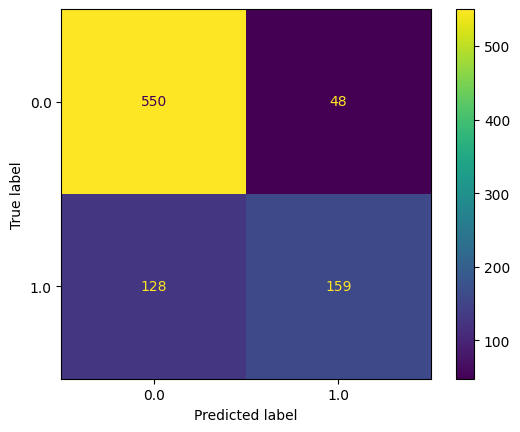

In [20]:
#scores = lc.pick_n_hidden(X_train, verbose=True, gaussianize='outliers')
#print(scores)
out = lc.Corex(n_hidden=8, verbose=False, gaussianize='outliers')  # A Corex model with 8 factors
out.fit(X_train)  # Fit the model on data
z_train = out.transform(X_train)  # Transform data into latent factors
z_test = out.transform(X_test)
print(out.clusters())  # See the clusters
cov = out.get_covariance()  # The covariance matrix

corex_model = LogisticRegression().fit(z_train, y_train)
train_score = corex_model.score(z_train, y_train)
test_score = corex_model.score(z_test, y_test)
y_preds = corex_model.predict(z_test)
print(f"Using CoRex with {out.m} features Train:{train_score} Test:{test_score} F-Score:{metrics.f1_score(y_test, y_pred)}")
ConfusionMatrixDisplay.from_predictions(y_test, y_preds)



In [19]:
1+0.5/np.mean(y_train)

2.560405643738977

In [34]:
expanded_X.columns[out.clusters() == 0]

Index(['ApplicationOrder_9', 'TimeOfDay_0', 'TimeOfDay_1', 'Nationality_17',
       'MotherQualification_18', 'MotherQualification_22',
       'FatherQualification_18', 'FatherQualification_25',
       'MotherOccupation_125', 'FatherOccupation_124', 'FatherOccupation_141',
       'FatherOccupation_195'],
      dtype='object')

In [ ]:
from sklearn.manifold import TSNE

time_start = time.time()

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))